In [ ]:
# %pip install --quiet netket

In [1]:
import netket
from flax.core.scope import CollectionFilter
from netket.utils.types import PyTree
from netket.operator import Squared
from functools import partial, lru_cache
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

import netket as nk
from netket import jax as nkjax
from netket.operator import DiscreteOperator, Squared
from netket.stats import Stats
from netket.utils.types import PyTree
from netket.utils.dispatch import dispatch

# from nektet.vqs import _ex
from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs.mc.common import force_to_grad
from netket.stats import Stats
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax, sigmay,sigmaz

In [84]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
# Define a 1d chain
L = 4
dis = 1
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
# ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

################################################################################
################################################################################
################################################################################
#이렇게 정의하는게 더 빨랑
ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
for i in range(L)])
################################################################################
################################################################################
################################################################################
# ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])

In [85]:
Et = np.random.uniform(low=0, high=L, size=None)
# Et = np.random.randint(0,L, size=1)
# Et = 9
Et


2.2178531017270817

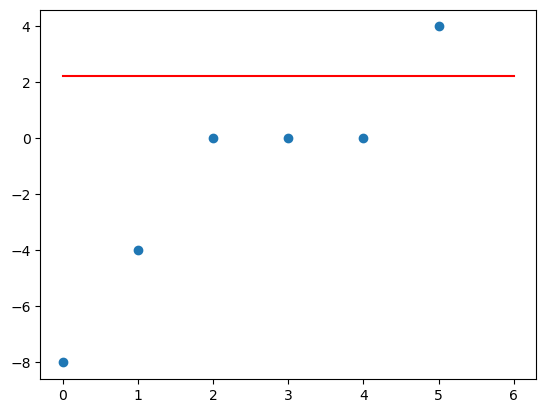

In [86]:
E, vec = np.linalg.eigh(ha.to_dense())
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')

In [87]:
E

array([-8.00000000e+00, -4.00000000e+00, -2.47963364e-16,  0.00000000e+00,
        2.73691106e-48,  4.00000000e+00])

In [88]:
ha_Et_inv  = np.linalg.inv((ha-Et).to_dense())
E_inv, vec_inv = np.linalg.eigh(ha_Et_inv)

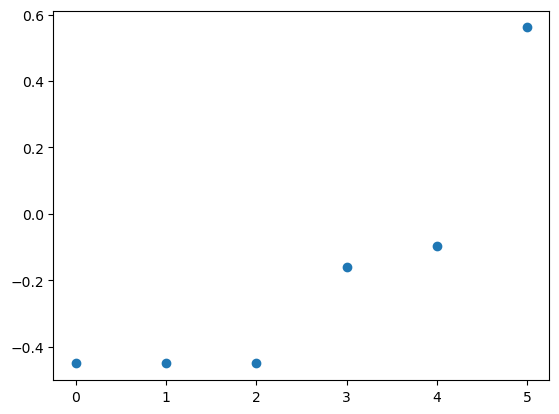

In [89]:
plt.scatter(range(len(E_inv)),E_inv)

In [90]:
E_inv
# -4.135835

array([-0.45088649, -0.45088649, -0.45088649, -0.16082722, -0.09786792,
        0.56112097])

In [91]:
def add(x,y):
    return x+y


In [92]:
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi

# from jax import jit
# @jit
def compute_energy(parameters):
    psi_gs = to_array(ma, parameters)
    return psi_gs.conj().T@(hamiltonian_jax_sparse@psi_gs)

In [103]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
# @partial(jax.jit, static_argnames='model')
def compute_gradient(parameters):
#     grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    # grad_fun = jax.jacrev(compute_energy, holomorphic=True)(parameters)
#     grad_fun = jax.jacfwd(compute_energy, holomorphic=True)(parameters)
    grad_fun = jax.jacfwd(compute_energy, holomorphic=True)(parameters)
    return grad_fun



In [104]:
O_sparse = ha.to_sparse()
H_Et_sparse = (ha-Et).to_sparse()
H_Et_squ_sparse = ((ha-Et)@(ha-Et)).to_sparse()

ha_jax = (ha).to_pauli_strings().to_jax_operator()
hamiltonian_jax_sparse = ha_jax.to_sparse()

In [105]:
gradient = compute_gradient(parameters)

In [106]:
@expect_and_grad.dispatch
def expect_and_grad_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *args,
    mutable: CollectionFilter = False,
    use_covariance: Optional[bool] = None,
    **kwargs,
) -> tuple[Stats, PyTree]:
    if use_covariance is None:
        use_covariance = Ô.is_hermitian

    if use_covariance:
        # Implementation of expect_and_grad for `use_covariance == True` (due to the Literal[True]
        # type in the signature).` This case is equivalent to the composition of the
        # `expect_and_forces` and `force_to_grad` functions.
        # return expect_and_grad_from_covariance(vstate, Ô, *args, mutable=mutable)
        Ō, Ō_grad = expect_and_forces(vstate, Ô, *args, mutable=mutable, **kwargs)
        Ō_grad = force_to_grad(Ō_grad, vstate.parameters)
        return Ō, Ō_grad
    else:
        raise NotImplementedError(
            "The gradient of non hermitian operators with "
            "FullSumState is not yet implemented"
        )

@nk.vqs.expect_and_forces.dispatch
def expect_and_forces_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *,
    mutable: CollectionFilter = False,
) -> tuple[Stats, PyTree]:
    if isinstance(Ô, Squared):
        raise NotImplementedError("expect_and_forces not yet implemented for `Squared`")

#     _check_hilbert(vstate, Ô)


    expval_O, Ō_grad = _exp_forces(
        vstate._apply_fun,
        mutable,
        vstate.parameters,
    )

    # if mutable is not False:
    #     vstate.model_state = new_model_state

    return expval_O, Ō_grad


@partial(jax.jit, static_argnums=(0, 1))
def _exp_forces(
    model_apply_fun: Callable,
    mutable: CollectionFilter,
    parameters: PyTree,
) -> tuple[PyTree, PyTree]:
    is_mutable = mutable is not False

    params = {'params':parameters}
    energy = compute_energy(params)
    gradient = compute_gradient(params)
    gradient = gradient['params']
    return (
        Stats(mean=energy, error_of_mean=0.0, variance=1.0),
        gradient,
        # new_model_state,
    )

In [107]:
def variance(vsta, hamiltonian):
    return vsta.to_array().conj()@(hamiltonian@hamiltonian).to_sparse()@vsta.to_array() - (vsta.to_array().conj()@(hamiltonian).to_sparse()@vsta.to_array())**2

100%|█| 10000/10000 [00:32<00:00, 309.48it/s, Energy=2.213e-05+4.235e-22j ± 0.00


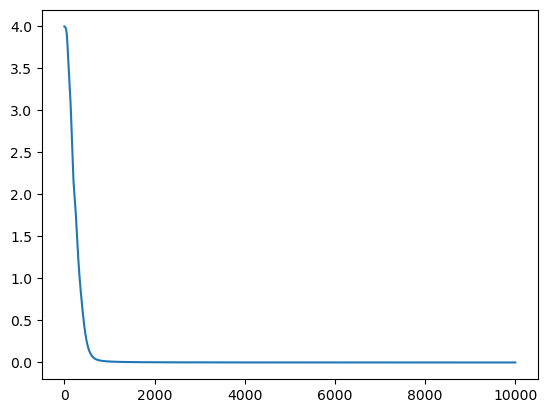

In [108]:
# Build the sampler
# sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
epochs = 10000


ma = nk.models.RBM(alpha=2, param_dtype=complex)
vs = nk.vqs.FullSumState(hi, ma)

# Optimizer
# op = nk.optimizer.Sgd(learning_rate=0.001)
op = nk.optimizer.Adam(learning_rate=0.001)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)


Target_ha = ha
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(epochs, out='RBM')
end = time.time()

data=json.load(open("RBM.log"))
plt.plot(data['Energy']['Mean']['real'])


In [109]:
variance(vs, ha)

Array(15.18562057+1.11022302e-15j, dtype=complex128)